In [1]:
import axisrules as axis
import numpy as np
import pandas as pd
import itertools
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:

axis_rules = [axis.VoterDeletion, axis.MinimalFlips, axis.BallotCompletion, 
              axis.MinimalSwaps, axis.ForbiddenTriples]

# Popularity

In [12]:
model = axis.OmmittedModel(0.45)
n_trys = 100
n_voters = 100
m_candidates = 7
scores = np.zeros(( len(axis_rules)+1, m_candidates))
for k in tqdm(range(n_trys)):
        profile = model(m_candidates, n_voters)
        scores_k = profile.sum(axis=0)
        scores[-1] += scores_k
        
        for i, rule in enumerate(axis_rules):
            axis_res = rule(profile).bruteforce()
            
            scores[i] += [scores_k[j] for j in axis_res[0][0]]
# scores /= n_trys

# scores *= 10
            
scores /= n_trys


100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


In [13]:
scores

array([[17.1 , 28.04, 36.45, 39.02, 36.6 , 28.99, 15.6 ],
       [16.75, 28.48, 36.59, 38.97, 36.8 , 28.62, 15.59],
       [16.56, 28.57, 36.78, 38.87, 36.88, 28.55, 15.59],
       [16.56, 28.57, 36.78, 38.86, 36.81, 28.63, 15.59],
       [16.6 , 28.55, 36.61, 39.02, 36.87, 28.56, 15.59],
       [16.56, 28.57, 36.63, 39.04, 36.85, 28.56, 15.59]])

# Quality 

In [8]:
models = [ axis.HammingModel(0.3)]
n_trys = 1000
n_voters = 100
m_candidates = 7
scores = np.zeros((len(models), len(axis_rules), n_trys))
for k in tqdm(range(n_trys)):
    for j, model in enumerate(models):
        profile = model(m_candidates, n_voters)
        for i, rule in enumerate(axis_rules):
            axis_res = rule(profile).bruteforce()
            minKT = axis.kandallTau(axis_res[0][0], range(m_candidates))
            for axis_res_i, _ in axis_res:
                minKT = min(minKT, axis.kandallTau(axis_res_i, range(m_candidates)))
                minKT = min(minKT, axis.kandallTau(axis_res_i, range(m_candidates)[::-1]))
            scores[j,i,k] = minKT
# scores /= n_trys

# scores *= 10
            
    

for i, model in enumerate(models):
    # save file 
    df = pd.DataFrame(scores[i,:,:].T, columns=[rule.name for rule in axis_rules], index=range(n_trys))
    df.to_csv(f"data/synthetic_{model.name}.csv")


scores = scores.sum(axis=2)
scores /= n_trys
scores *= 10




100%|██████████| 1000/1000 [17:23<00:00,  1.04s/it]


In [9]:
# make the score into a nice table 
scoresdf = pd.DataFrame(scores.T, columns=["Hamming"], index=[rule.name for rule in axis_rules])scoresdf

,Hamming
Voter Deletion,33.47
Minimal Flips,29.29
Ballot Completion,28.32
Minimal Swaps,27.02
Forbidden Triples,27.81


In [6]:
n_candidates = 7
basiclist = list(range(n_candidates))
reversedlist = list(range(n_candidates))[::-1]

# iter over all possible permutations of the basiclist

maxKT = 0
for perm in tqdm(itertools.permutations(basiclist)):
    maxKT = max(maxKT, axis.kandallTau(perm, reversedlist))
    maxKT = max(maxKT, axis.kandallTau(perm, basiclist))
print(maxKT)

362880it [00:26, 13607.99it/s]

18


# Popularity

In [17]:
model = axis.DistancePopularityModel(alpha=1, beta=1)
n_trys = 1000
n_candidates = 6
n_voters = 500
popularity_positions = np.zeros((len(axis_rules)+1, n_candidates))

for _ in tqdm(range(n_trys)):

    profile = model(n_candidates,n_voters)
    approval_scores = profile.sum(axis=0)
    axis_profile = model.axis
    popularity_positions[-1] += np.array([approval_scores[axis_profile[i]] for i in range(n_candidates)])
    # print("Axis profile: ", axis_profile)

    for j, rule in enumerate(axis_rules):
        # print(rule.name)
        res = rule(profile).bruteforce()
        best_axis, score = res[0]
        approval_positions = [approval_scores[best_axis[i]] for i in range(n_candidates)]
        popularity_positions[j] += np.array(approval_positions)

popularity_positions /= n_trys

100%|██████████| 1000/1000 [01:16<00:00, 13.15it/s]


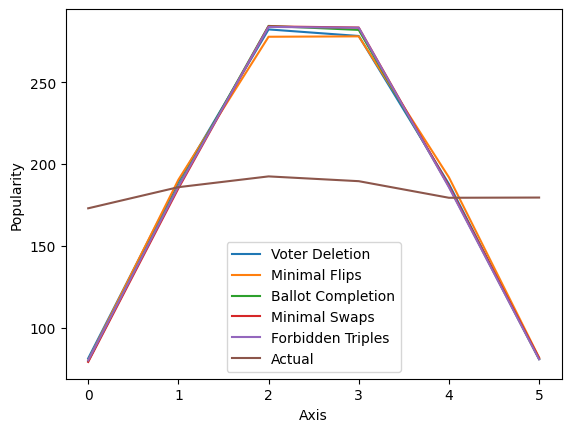

In [18]:


for j, rule in enumerate(axis_rules):
    plt.plot(popularity_positions[j], label=rule.name)

plt.plot(popularity_positions[-1], label="Actual")

plt.xlabel("Axis")
plt.ylabel("Popularity")
plt.legend()
plt.show()

In [32]:
model = axis.DistancePopularityModel(alpha=1, beta=0.5)
n_trys = 1000
n_candidates = 6
n_voters = 500
popularity_positions = np.zeros((len(axis_rules)+1, 10))

for _ in tqdm(range(n_trys)):

    profile = model(n_candidates,n_voters)
    approval_scores = profile.sum(axis=0)
    axis_profile = model.axis
    # popularity_positions[-1] += np.array([approval_scores[axis_profile[i]] for i in range(n_candidates)])
    # print("Axis profile: ", axis_profile)

    for i in range(n_candidates):
        app_score = approval_scores[axis_profile[i]]//(n_voters//10)
        app_score = int(app_score)
        popularity_positions[-1, app_score] += 1

    for j, rule in enumerate(axis_rules):
        # print(rule.name)
        res = rule(profile).bruteforce()
        best_axis, score = res[0]
        for i in range(n_candidates):
            app_score = approval_scores[best_axis[i]]//(n_voters//10)
            app_score = int(app_score)
            if i < n_candidates//2:
                popularity_positions[j, app_score] += i 
            else:
                popularity_positions[j, app_score] += n_candidates - 1 - i

for i in range(len(axis_rules)):
    popularity_positions[i] /= popularity_positions[-1]

100%|██████████| 1000/1000 [02:26<00:00,  6.81it/s]
C:\Users\teoz0\AppData\Local\Temp\ipykernel_28008\2178367640.py:33: RuntimeWarning: invalid value encountered in divide
  popularity_positions[i] /= popularity_positions[-1]


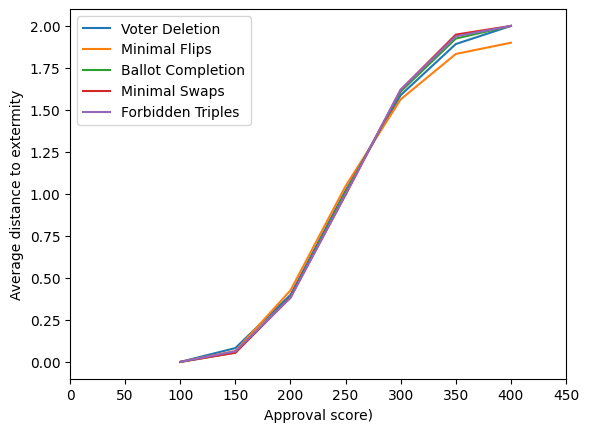

In [36]:
for j, rule in enumerate(axis_rules):
    plt.plot(popularity_positions[j], label=rule.name)

plt.xticks(range(10), [str(i*50) for i in range(10)])
plt.xlabel("Approval score)")
plt.ylabel("Average distance to extermity")
plt.legend()
plt.show()

In [31]:
popularity_positions

array([[           nan,            nan, 0.00000000e+00, 6.39514731e-01,
        9.72704715e-01, 9.74080772e-01, 1.04986150e+00, 1.31746032e+00,
        1.38461538e+00,            nan],
       [           nan,            nan, 0.00000000e+00, 6.39514731e-01,
        9.72704715e-01, 9.74080772e-01, 1.04986150e+00, 1.31746032e+00,
        1.38461538e+00,            nan],
       [           nan,            nan, 0.00000000e+00, 6.39514731e-01,
        9.72704715e-01, 9.74080772e-01, 1.04986150e+00, 1.31746032e+00,
        1.38461538e+00,            nan],
       [           nan,            nan, 0.00000000e+00, 6.39514731e-01,
        9.72704715e-01, 9.74080772e-01, 1.04986150e+00, 1.31746032e+00,
        1.38461538e+00,            nan],
       [           nan,            nan, 0.00000000e+00, 6.39514731e-01,
        9.72704715e-01, 9.74080772e-01, 1.04986150e+00, 1.31746032e+00,
        1.38461538e+00,            nan],
       [0.00000000e+00, 0.00000000e+00, 2.00000000e+00, 5.77000000e+02,
   

# Subsampling

In [3]:
path_dataset = "../data/" 
import os
list_datasets = []

for folder in os.listdir(path_dataset):
    for dataset in os.listdir(path_dataset+folder):
        candidates = path_dataset+folder+"/candidates.csv"
        # Test isdir 
        if os.path.isdir(path_dataset+folder+"/"+dataset):
            path_weights=  path_dataset+folder+"/"+dataset+"/weights.csv" 
            # Test if there is weight file:
            isweight = False
            if os.path.isfile(path_weights):
                isweight = True
            for file in os.listdir(path_dataset+folder+"/"+dataset+"/votes"):
                if file.endswith(".csv"):
                    list_datasets.append({"votes":path_dataset+folder+"/"+dataset+"/votes/"+file, 
                                            "weights":path_weights,
                                            "isweight":isweight,
                                            "candidates": candidates,
                                            "year": folder,
                                            "dataset": dataset,
                                            "file":file})


In [20]:
path_votes = '../data/France 2022/Online/votes/approval.csv'
path_weights = '../data/France 2022/Online/weights.csv'

df_votes = pd.read_csv(path_votes, index_col=0).values 
df_weights = pd.read_csv(path_weights, index_col=0)["approval"].values 


model = axis.SamplingModel(df_votes, df_weights)


In [21]:
n_trys = 1000
n_candidates = 7
n_voters = 500
popularity_positions = np.zeros((len(axis_rules)+1, n_candidates))

for _ in tqdm(range(n_trys)):

    profile, weights = model(n_candidates,n_voters)
    approval_scores = profile.sum(axis=0)
    # print("Axis profile: ", axis_profile)
    order = np.argsort(approval_scores)
    sp_axis = np.zeros(n_candidates, dtype=int)
    for i in range(n_candidates):
        if i%2 == 0:
            sp_axis[i//2] = order[i]
        else:
            sp_axis[n_candidates-1-i//2] = order[i]
    popularity_positions[-1] += np.array([approval_scores[sp_axis[i]] for i in range(n_candidates)])


    for j, rule in enumerate(axis_rules):
        # print(rule.name)
        res = rule(profile, weights).bruteforce()
        best_axis, score = res[0]
        approval_positions = [approval_scores[best_axis[i]] for i in range(n_candidates)]
        popularity_positions[j] += np.array(approval_positions)

popularity_positions /= n_trys

100%|██████████| 1000/1000 [01:00<00:00, 16.59it/s]


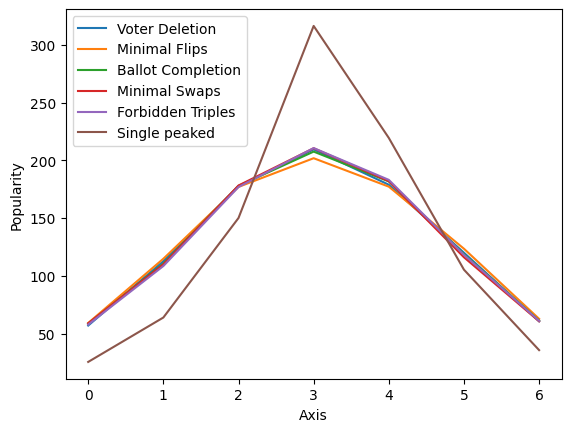

In [24]:

for j, rule in enumerate(axis_rules):
    plt.plot(popularity_positions[j], label=rule.name)

plt.plot(popularity_positions[-1], label="Single peaked")
plt.xlabel("Axis")
plt.ylabel("Popularity")
plt.legend()
plt.show()

In [ ]:
n_trys = 1000
n_candidates = 7
n_voters = 500
popularity_positions = np.zeros((len(axis_rules)+1, n_candidates))

for _ in tqdm(range(n_trys)):

    profile, weights = model(n_candidates,n_voters)
    approval_scores = profile.sum(axis=0)
    # print("Axis profile: ", axis_profile)
    order = np.argsort(approval_scores)
    sp_axis = np.zeros(n_candidates, dtype=int)
    for i in range(n_candidates):
        if i%2 == 0:
            sp_axis[i//2] = order[i]
        else:
            sp_axis[n_candidates-1-i//2] = order[i]
    popularity_positions[-1] += np.array([approval_scores[sp_axis[i]] for i in range(n_candidates)])


    for j, rule in enumerate(axis_rules):
        # print(rule.name)
        res = rule(profile, weights).bruteforce()
        best_axis, score = res[0]
        approval_positions = [approval_scores[best_axis[i]] for i in range(n_candidates)]
        popularity_positions[j] += np.array(approval_positions)

popularity_positions /= n_trys